In [1]:
import cell2fate as c2f
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import os
data_name = 'Pancreas_with_cc'

Global seed set to 0


You need to change this to suitable directories on your system:

In [2]:
# Data name, where to download data and where to save results
data_path = '/nfs/team283/aa16/data/fate_benchmarking/benchmarking_datasets/Pancreas_with_cc/'
results_path = '/nfs/team283/aa16/cell2fate_paper_results/'

In [3]:
# Downloading data into specified directory:
os.system('cd ' + data_path + ' && wget -q https://cell2fate.cog.sanger.ac.uk/' + data_name + '/' + data_name + '_anndata.h5ad')

0

Load the data and extract most variable genes (and optionally remove some clusters).

In [4]:
adata = sc.read_h5ad(data_path + data_name + '_anndata.h5ad')
clusters_to_remove = []
adata = c2f.utils.get_training_data(adata, cells_per_cluster = 10**5, cluster_column = 'clusters',
                                    remove_clusters = clusters_to_remove,
                                min_shared_counts = 20, n_var_genes= 3000)

Keeping at most 100000 cells per cluster
Filtered out 20801 genes that are detected 20 counts (shared).
Extracted 3000 highly variable genes.


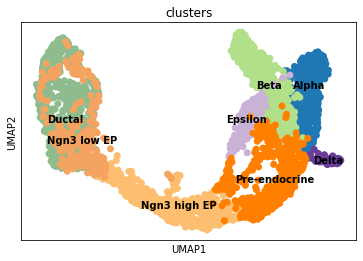

In [5]:
fig, ax = plt.subplots(1,1, figsize = (6, 4))
sc.pl.umap(adata, color = ['clusters'], s = 200, legend_loc='on data', show = False, ax = ax)
plt.savefig(results_path + data_name + 'UMAP_clusters.pdf')

We initialize the model, which includes automatically setting a maximal number of modules, based on the number of Louvain clusters (times 1.15) in the data.

In [6]:
c2f.Cell2fate_DynamicalModel.setup_anndata(adata, spliced_label='spliced', unspliced_label='unspliced')

In [7]:
n_modules = c2f.utils.get_max_modules(adata)

Leiden clustering ...
Number of Leiden Clusters: 13
Maximal Number of Modules: 14


In [8]:
mod = c2f.Cell2fate_DynamicalModel(adata, n_modules = n_modules)

Training the model:

In [9]:
mod.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [08:22<00:00,  1.01s/it, v_num=1, elbo_train=1.13e+7]


Exporting relevant model parameters to the anndata object:

In [10]:
adata = mod.export_posterior(adata)

sample_kwargs['batch_size'] 3696
Sampling global variables, sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.70it/s]


One of the interesting parameter posteriors that was saved to the anndata object is the differentiation time:

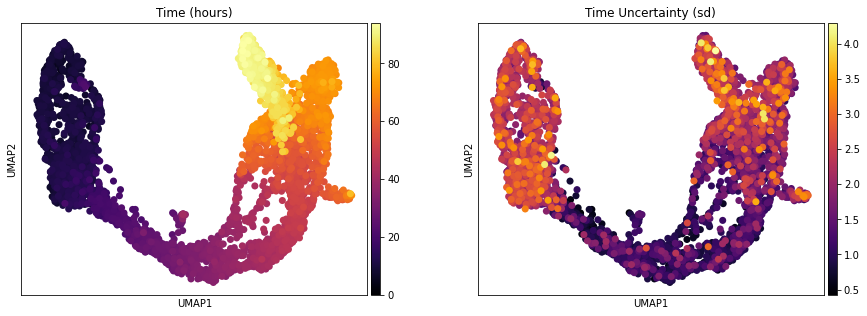

In [11]:
fig, ax = plt.subplots(1,2, figsize = (15, 5))
sc.pl.umap(adata, color = ['Time (hours)'], legend_loc = 'right margin',
                size = 200, color_map = 'inferno', ncols = 2, show = False, ax = ax[0])
sc.pl.umap(adata, color = ['Time Uncertainty (sd)'], legend_loc = 'right margin',
                size = 200, color_map = 'inferno', ncols = 2, show = False, ax = ax[1])
plt.savefig(results_path + data_name + 'UMAP_Time_nModules' + str(n_modules) + '.pdf')

We can compute some module statistics to visualize the activity of the underlying modules:

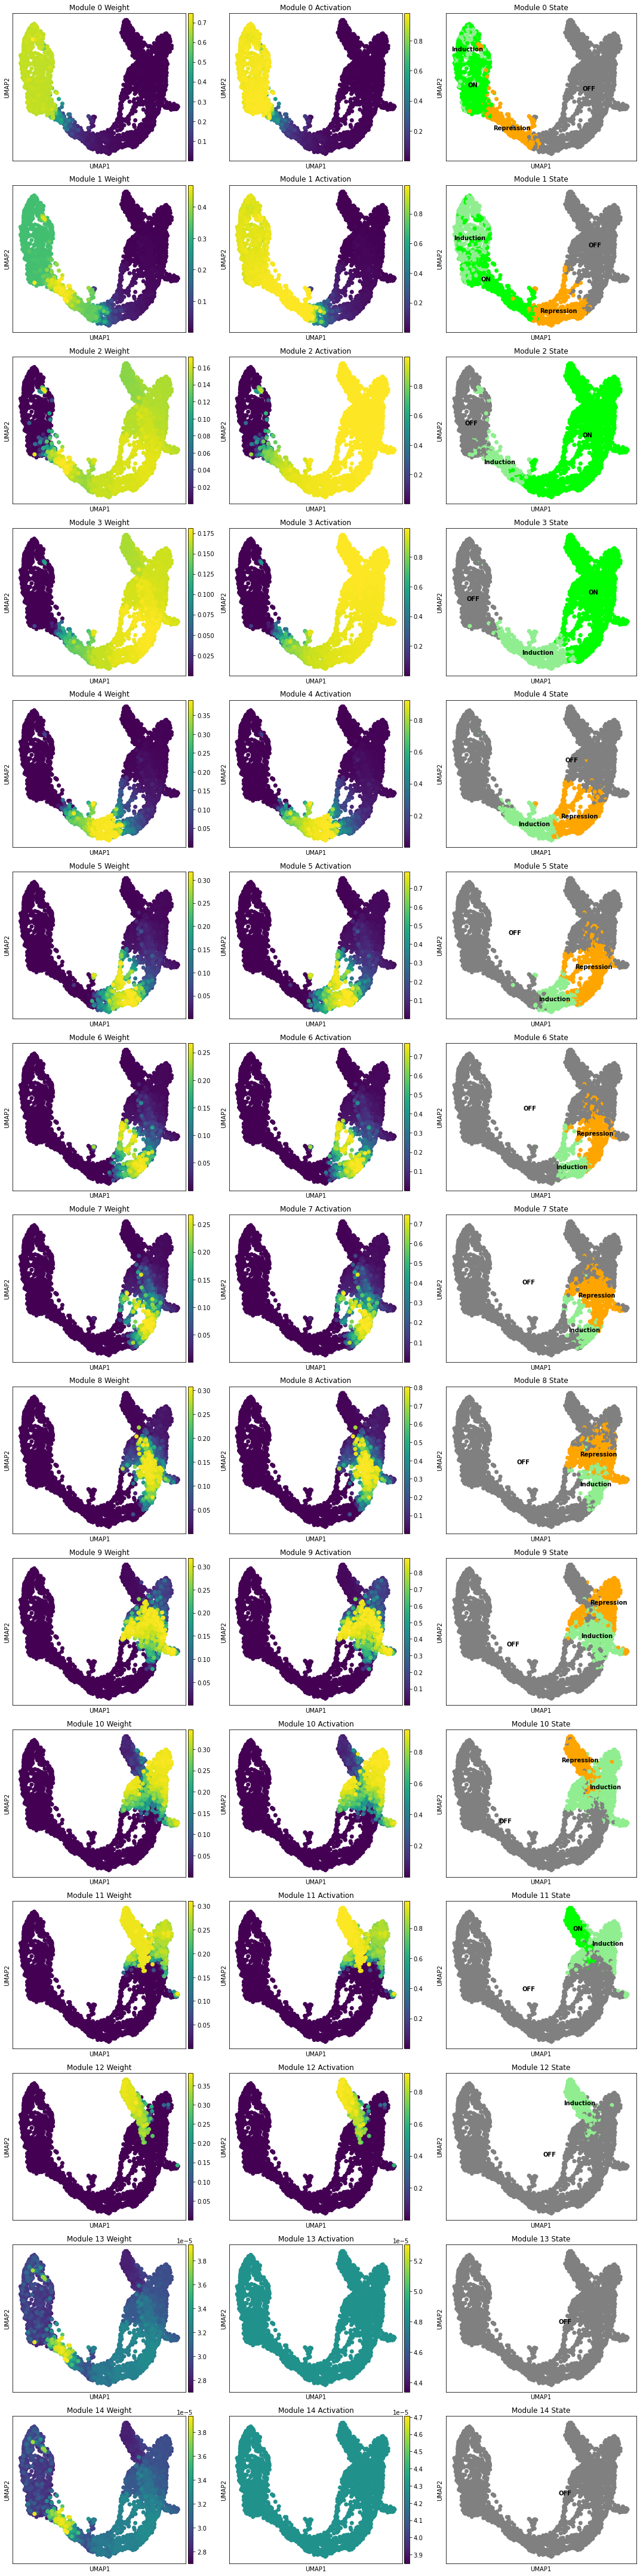

In [12]:
adata = mod.compute_module_summary_statistics(adata)
mod.plot_module_summary_statistics(adata, save = results_path + data_name + 'module_summary_stats_plot.pdf')

This is an alternative way to visualize module activation over time:

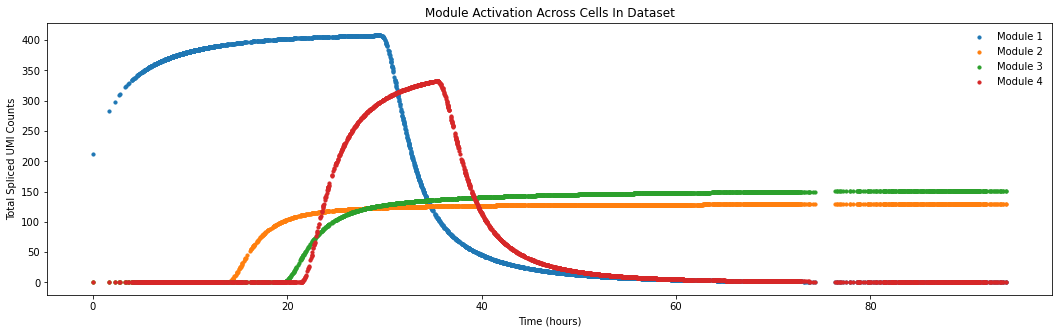

In [13]:
mod.compare_module_activation(adata, chosen_modules = [1,2,3,4],
                         save = results_path + data_name + 'module_activation_comparison.pdf')

For large datasets (> 10000 cells) we recommend the scalable scVelo workflow for computing and plotting the velocity graph, which is used in this method:

Computing total RNAvelocity ...


  0%|          | 0/3696 [00:00<?, ?cells/s]

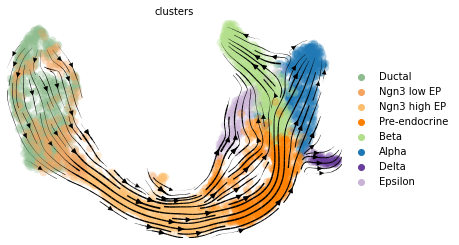

In [22]:
mod.compute_and_plot_total_velocity_scvelo(adata, save = results_path + data_name + 'total_velocity_plots.png', delete = False)

For smaller datasets (< 10000 cells) our own method that takes into account posterior uncertainty, when computing the velocity graph can be used:

Computing total RNAvelocity ...


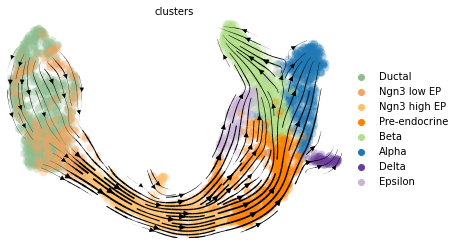

In [15]:
mod.compute_and_plot_total_velocity(adata, save = results_path + data_name + 'total_velocity_plots.png', delete = False)

The delete=False command saves the RNA velocity for each gene in both cases in an adata.layers slot.

For a visualization that is more similar to the scvelo plots:

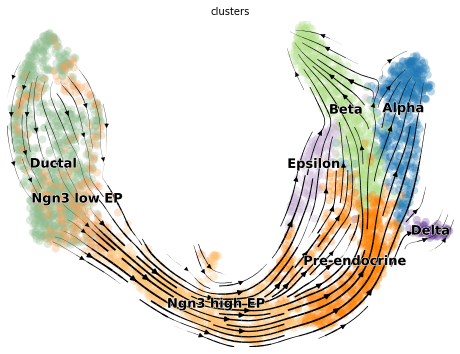

In [16]:
import scvelo as scv
fix, ax = plt.subplots(1, 1, figsize = (8, 6))
scv.pl.velocity_embedding_stream(adata, basis='umap', save = False, vkey='Velocity',
                                 show = False, ax = ax, legend_fontsize = 13)
plt.savefig(results_path + data_name + 'total_velocity_plots.png')

In [21]:
adata

AnnData object with n_obs × n_vars = 3696 × 3000
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', '_indices', '_scvi_batch', 'Time (hours)', 'Time Uncertainty (sd)', 'Module 0 Weight', 'Module 0 Activation', 'Module 0 State', 'Module 1 Weight', 'Module 1 Activation', 'Module 1 State', 'Module 2 Weight', 'Module 2 Activation', 'Module 2 State', 'Module 3 Weight', 'Module 3 Activation', 'Module 3 State', 'Module 4 Weight', 'Module 4 Activation', 'Module 4 State', 'Module 5 Weight', 'Module 5 Activation', 'Module 5 State', 'Module 6 Weight', 'Module 6 Activation', 'Module 6 State', 'Module 7 Weight', 'Module 7 Activation', 'Module 7 State', 'Module 8 Weight', 'Module 8 Activation', 'Module 8 State', 'Module 9 Weight', 'Module 9 Activation', 'Module 9 State', 'Module 10 Weight', 'Module 10 Activation', 'Module 10 State', 'Module 11 Weight', 'Module 11 Activation', 'Module 11 State', 'Module 12 Weight', 'Module

Technical variables usually show lower detection efficiency and higher noise (= lower overdispersion parameter) for unspliced counts:

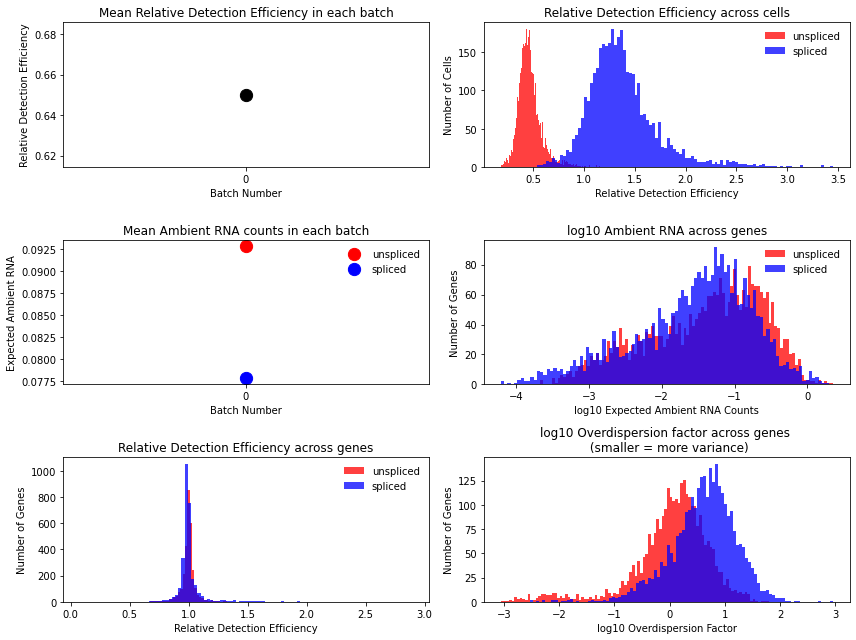

In [18]:
mod.plot_technical_variables(adata, save = results_path + data_name + 'technical_variables_overview_plot.pdf')

This is how to have a look at the various rate parameters the optimization converged to:

In [19]:
print('A_mgON mean:', np.mean(mod.samples['post_sample_means']['A_mgON']))
print('gamma_g mean:', np.mean(mod.samples['post_sample_means']['gamma_g']))
print('beta_g mean:', np.mean(mod.samples['post_sample_means']['beta_g']))
print('lam_mi, all modules: \n \n', np.round(mod.samples['post_sample_means']['lam_mi'],2))

A_mgON mean: 0.06243453
gamma_g mean: 0.82418305
beta_g mean: 0.86586314
lam_mi, all modules: 
 
 [[[2.22 1.4 ]]

 [[2.77 2.34]]

 [[3.05 2.32]]

 [[2.24 1.98]]

 [[2.74 2.12]]

 [[2.86 1.98]]

 [[2.96 2.34]]

 [[2.89 2.34]]

 [[2.8  1.8 ]]

 [[3.64 3.08]]

 [[3.42 1.3 ]]

 [[3.39 1.02]]

 [[3.15 2.13]]

 [[1.36 1.73]]

 [[1.78 1.2 ]]]


This method returns orders the genes and TFs in each module from most to least enriched. And it also performs gene set enrichment analysis:

In [20]:
tab, all_results = mod.get_module_top_features(adata, p_adj_cutoff=0.01, background = adata.var_names)
tab.to_csv(results_path + data_name + 'module_top_features_table.csv')

In [21]:
tab

,Module Number,Genes Ranked,TFs Ranked,Terms Ranked
0,0,"Adamts16, Smtnl2, S100b, Gja1, Rest, Gsta3, Cy...","Rest, Ehf, Hes1, Nr4a1, Sox9, Zfp36l1, Zfp637,...","regulation of cell cycle (GO:0051726), membran..."
1,1,"Grin3a, Spink4, Ckb, Dll1, Serpina1c, Rtkn, Te...","Tead2, Bcl11b, Ovol2, Dach2, Klf13, Nfix, Crem...",
2,2,"Ypel5, Smim13, Kremen1, Kif19a, Efcab1, Gm1544...","Arid3a, Zbtb16, Foxn3, Ncor2, Rfx3, Mef2d, Nkx...",
3,3,"Chga, Samd14, Mcf2l, Pomt2, B4galt5, Slc25a25,...","Hsf2, Meis3, Rc3h2, Satb1, Smad1, Tox4, Dmtf1,...",
4,4,"Btbd11, Adamts18, Notum, Megf11, Scube1, Dock4...","Zfp423, Neurog3, D630045J12Rik, Smarcd2, Lmx1b...",
5,5,"Clstn2, Stxbp5l, Ctnna3, Chst9, Akt3, Bach2, D...","Bach2, Runx1t1, Nfatc2, Ebf1, Hivep1, Aff2, Pl...",
6,6,"Ncam2, Sulf1, Asic2, St8sia2, Ebf1, Mboat4, Lr...","Ebf1, Prdm16, Rfx2, Znfx1, Gmeb2, Runx1t1, St1...",
7,7,"Ccl9, Ccl4, Sdk1, Tmem178b, Hdc, Gm13373, Apba...","Zbtb10, Zfp90, Vdr, Creb3, Purg, Sim1, Rfx2, N...",
8,8,"Pik3c2g, Serpinb1a, Filip1, Blnk, Plac8, Samd5...","Zfp804a, Mnx1, Zbtb7c, Zfp672, Tshz3, Zfp174, ...",
9,9,"Ctnna2, Fam159b, Ppp1r14c, Tshz3, Gm2115, Lmo3...","Tshz3, Xbp1, Arx, Plag1, Vdr, Zfp719, Pax6, Pd...",


In [22]:
all_results[0]

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,regulation of cell cycle (GO:0051726),10/296,0.000002,0.001026,0,0,7.620047,98.870054,NOTCH2;NR4A1;CCNB1;CDK6;HPGD;CCND1;GMNN;SOX9;F...
1,GO_Biological_Process_2021,membrane raft assembly (GO:0001765),3/6,0.000002,0.001026,0,0,205.123711,2654.369515,ANXA2;EMP2;S100A10
2,GO_Biological_Process_2021,positive regulation of cellular process (GO:00...,14/625,0.000003,0.001026,0,0,5.139230,65.855682,CYBA;EMP2;PTN;S100B;ZFP36L1;CXCL12;CDH3;CCND1;...
3,GO_Biological_Process_2021,regulation of osteoblast differentiation (GO:0...,6/83,0.000004,0.001026,0,0,16.432440,205.463570,REST;CDK6;WNT7B;FBXO5;SOX9;FGFR2
4,GO_Biological_Process_2021,positive regulation of cell population prolife...,12/474,0.000004,0.001026,0,0,5.737308,70.835691,BST2;GJA1;CDK6;HES1;EMP2;SOX9;PTN;FBXO5;GAS6;S...
5,GO_Biological_Process_2021,regulation of keratinocyte proliferation (GO:0...,4/24,0.000006,0.001026,0,0,41.416667,499.467131,NOTCH2;CDH3;FGFR2;ZFP36L1
6,GO_Biological_Process_2021,regulation of cell population proliferation (G...,15/764,0.000006,0.001026,0,0,4.512134,54.411584,UHRF1;OSGIN1;EMP2;PTN;S100B;ZFP36L1;REST;CDK6;...
7,GO_Biological_Process_2021,regulation of epithelial cell proliferation (G...,6/93,0.000007,0.001117,0,0,14.536317,172.123409,NR4A1;CDK6;UHRF1;SOX9;FGFR2;ZFP36L1
8,GO_Biological_Process_2021,L-serine metabolic process (GO:0006563),3/10,0.000014,0.001955,0,0,87.892489,981.154450,CBS;PSAT1;PHGDH
9,GO_Biological_Process_2021,serine family amino acid biosynthetic process ...,3/12,0.000026,0.003202,0,0,68.353952,722.108703,CBS;PSAT1;PHGDH


To plot the expression and RNA velocity of individual module marker genes:

<AxesSubplot:title={'center':'Npy velocity'}, xlabel='UMAP1', ylabel='UMAP2'>

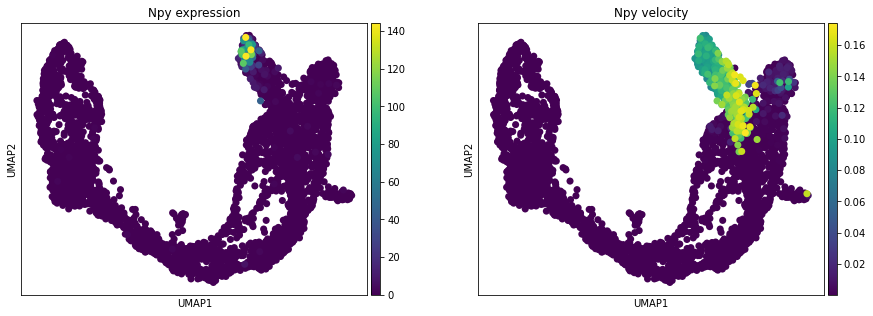

In [50]:
gene = 'Npy'
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
sc.pl.umap(adata, color = [gene], s = 200, legend_loc='on data', show = False,
           title = gene + ' expression', ax = ax[0])
sc.pl.umap(adata, color = [gene], s = 200, legend_loc='on data', show = False,
           layer = 'velocity', title = gene + ' velocity', ax = ax[1])